In [1]:
import os
import json

import numpy as np
from tqdm import tqdm, trange

from scipy.spatial import cKDTree

import torch
from torch.optim import Adam
from torch.autograd import Function
from torch_geometric.data import Data, DataLoader

class PairwiseGraphBuilder:
    def __init__(self, X, locations, specimen=None, n_neighbors=10, node_meta = {}, edge_meta = {}):
        if isinstance(locations, torch.Tensor):
            locations = locations.cpu().numpy()
        if specimen is not None and isinstance(specimen, torch.Tensor):
            specimen = specimen.cpu().numpy()
        
        # Setup Data
        self.X = torch.tensor(X)
        self.locations = torch.tensor(locations)
        self.specimen = torch.tensor(specimen) if specimen is not None else None
        self.n_neighbors = n_neighbors
        self.ckd_tree = cKDTree(locations)

        self.node_meta = node_meta
        self.edge_meta = edge_meta

        # Compute nearest neighbors
        self._get_nearest_neighbors()

    def _get_nearest_neighbors(self):
        distances, indices = self.ckd_tree.query(self.locations, k=self.n_neighbors)
        self.indices = indices
        self.distances = distances
    
    def _fully_connected_graph(self, positions, include_self=True, device=None):
        if isinstance(positions, torch.Tensor):
            pos = positions
        else:
            pos = torch.tensor(positions, dtype=torch.float)

        N = pos.size(0)

        # Compute pairwise distance matrix
        dist_matrix = torch.cdist(pos, pos, p=2)  # (N, N)

        # Get all possible edges (i,j)
        src, dst = torch.meshgrid(
            torch.arange(N, device=pos.device),
            torch.arange(N, device=pos.device),
            indexing='ij'
        )

        # Optionally remove self-edges
        if not include_self:
            mask = src != dst
            src, dst = src[mask], dst[mask]
            edge_attr = dist_matrix[mask].unsqueeze(1)
        else:
            src, dst = src.reshape(-1), dst.reshape(-1)
            edge_attr = dist_matrix.reshape(-1, 1)

        edge_index = torch.stack([src, dst], dim=0)

        if device is not None:
            edge_index = edge_index.to(device)
            edge_attr = edge_attr.to(device)

        return edge_index, edge_attr
    
    def _construct_subgraph(self, index):
        # clone to avoid in-place edits
        X = self.X[self.indices[index]].clone()

        # Trying to avoid having the graph just pass information about the center node
        # Under global pooling conditions, I doubt it would ever actually leak in a 
        # due to the mixing that is going to go on, but I'm not going to risk that. I
        # also want to see if it would work if I only pass the center node's learned
        # embedding. 
        target = X[0]
        masked_X = X.clone()
        local_positions = self.locations[self.indices[index]]  # fixed typo
        edge_index, edge_attr = self._fully_connected_graph(local_positions)

        # I had some problems, now no more.
        assert edge_index.max() < X.size(0), "Edge indices exceed node count!"

        # Add specimen info if available
        if self.specimen is not None:
            specimen_label = self.specimen[self.indices[index]][0]
        else:
            specimen_label = -1

        data = Data(
            X=masked_X,
            edge_index=edge_index,
            edge_attr=edge_attr,
            target=target[None, :],
            specimen=specimen_label
        )

        for k, v in self.node_meta.items():
            data[k] = torch.tensor(v[self.indices[index]])
        for k, v in self.edge_meta.items():
            data[k] = torch.tensor(v[self.indices[index]])

        return data

    def create_dataloader(self, batch_size=64, shuffle=True):
        return DataLoader(
            [self._construct_subgraph(i) for i in trange(self.X.shape[0])],
            batch_size=batch_size,
            shuffle=shuffle
        )

In [2]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax

import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax


class EdgeEmbeddingAttnConv(MessagePassing):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        edge_dim: int = 16,
        edge_attr_dim: int = 1,
        hidden_dim: int = 128,
        aggr: str = "add",
        attn_dropout: float = 0.0,
    ):
        super().__init__(aggr=aggr)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.edge_dim = edge_dim
        self.edge_attr_dim = edge_attr_dim

        # Node -> message value
        self.lin_v = nn.Linear(in_dim, out_dim, bias=False)

        # This is the "edge_mlp equivalent": produces an edge embedding per edge.
        self.edge_encoder = nn.Sequential(
            nn.Linear(2 * in_dim + self.edge_attr_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, edge_dim),
        )

        # Use edge embedding to get attention logits (scalar per edge)
        self.attn_proj = nn.Linear(edge_dim, 1, bias=False)

        # Optional: use edge embedding to gate each message dimension (vector gate)
        self.gate_proj = nn.Linear(edge_dim, out_dim, bias=True)

        self.attn_dropout = nn.Dropout(attn_dropout)

        # For inspection
        self.last_alpha = None
        self.last_edge_emb = None

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor):
        # propagate returns node updates; edge embeddings are stored for inspection
        out = self.propagate(edge_index=edge_index, x=x, edge_attr=edge_attr)
        return out

    def message(self, x_j, x_i, edge_attr, index, ptr, size_i):
        # Edge embedding e_ij: [E, edge_dim]
        e_ij = self.edge_encoder(torch.cat([x_j, x_i, edge_attr], dim=-1))
        self.last_edge_emb = e_ij.detach()

        # Attention weights alpha_ij: normalize over incoming edges of node i
        logits = self.attn_proj(e_ij).squeeze(-1)  # [E]
        alpha = softmax(logits, index, ptr, size_i)  # [E]
        alpha = self.attn_dropout(alpha)
        self.last_alpha = alpha.detach()

        # Message value + edge-conditioned gate
        v = self.lin_v(x_j)  # [E, out_dim]
        gate = torch.sigmoid(self.gate_proj(e_ij))  # [E, out_dim]

        return (v * gate) * alpha.unsqueeze(-1)



In [3]:
import numpy as np
import scanpy as sc
import pyro.distributions as dist

adata = sc.read_h5ad("../data/data.h5ad")
adata = adata[adata.obs["folder"].eq("04-44")]

In [4]:

pgb = PairwiseGraphBuilder(
    adata.X,
    adata.obs[["x_centroid", "y_centroid"]].values, 
    specimen=adata.obs["folder"].cat.codes.values, 
    n_neighbors=10,
    node_meta = {
        "oro": torch.tensor(np.log1p(adata.obs["oil_red_o_area"]).values),
        "cell_type": torch.tensor(adata.obs["cell_type"].cat.codes),
        "niche_embedding": torch.tensor(adata.obsm["latent_representation"]),
        "cell_embedding": torch.tensor(adata.obsm["X_token"]),
        "counts": torch.tensor(adata.layers["transcript"]),
        "centroids": torch.tensor(adata.obs[["x_centroid", "y_centroid"]].values)
    },
)

dataloader = pgb.create_dataloader(batch_size=256)

/tmp/ipykernel_317092/1412843128.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "cell_type": torch.tensor(adata.obs["cell_type"].cat.codes),
  0%|          | 0/37037 [00:00<?, ?it/s]/tmp/ipykernel_317092/2833807056.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data[k] = torch.tensor(v[self.indices[index]])
100%|██████████| 37037/37037 [00:13<00:00, 2742.10it/s]
/tmp/ipykernel_317092/2833807056.py:113: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  return DataLoader(


In [ ]:
for batch in dataloader:
    break

/home/jhaberbe/Projects/Personal/DEC2025/edge_embeddings/.venv/lib/python3.13/site-packages/torch_geometric/data/data.py:187: UserWarning:

Unable to accurately infer 'num_nodes' from the attribute set '{'X', 'edge_index', 'oro', 'target', 'niche_embedding', 'cell_type', 'counts', 'centroids', 'edge_attr', 'cell_embedding', 'specimen'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning

/home/jhaberbe/Projects/Personal/DEC2025/edge_embeddings/.venv/lib/python3.13/site-packages/torch_geometric/data/collate.py:142: UserWarning:

Unable to accurately infer 'num_nodes' from the attribute set '{'X', 'edge_index', 'oro', 'target', 'niche_embedding', 'cell_type', 'counts', 'centroids', 'edge_attr', 'cell_embedding', 'specimen'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning



In [121]:
import torch.nn
import torch_geometric.nn

In [128]:
in_channels = 366
out_channels = 64

In [ ]:
GAT_1 = torch_geometric.nn.GATConv(
    in_channels=in_channels, 
    out_channels=out_channels,
    edge_dim=1
)

GAT_2 = torch_geometric.nn.GATConv(
    in_channels=64, 
    out_channels=3,
    edge_dim=64
)

# Transformer Encoder Layer
STA = torch_geometric.nn.SetTransformerAggregation(channels=64, heads=8)

# Node Update Layer
node_update_layer = torch.nn.Sequential(
    torch.nn.Linear(in_features=in_channels + 64, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(in_features=256, out_features=128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(in_features=128, out_features=64),
)

edge_embedding_layer = torch.nn.Sequential(
    torch.nn.Linear(in_features=64 * 2 + 1, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(in_features=256, out_features=128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(in_features=128, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
)

x_1 = GAT_1.forward(batch_data.X, batch_data.edge_index, edge_attr=batch_data.edge_attr.float())
m_1 = STA(x_1, index=batch_data.batch)

x_2 = node_update_layer(torch.cat([batch_data.X, m_1[batch_data.batch]], axis=1))

e_2 = edge_embedding_layer(
    torch.cat([x_2[batch_data.edge_index[0]], x_2[batch_data.edge_index[1]], batch_data.edge_attr.float()], axis=1)
)

GAT_2(x_2, batch_data.edge_index, edge_attr=e_2)

tensor([[ 0.0461,  0.0461, -0.0053],
        [ 0.0457,  0.0453, -0.0053],
        [ 0.0455,  0.0456, -0.0052],
        ...,
        [ 0.0499,  0.0271, -0.0325],
        [ 0.0514,  0.0285, -0.0316],
        [ 0.0516,  0.0279, -0.0311]], grad_fn=<AddBackward0>)

In [244]:
class WeaveNetwork(torch.nn.Module):

    def __init__(self, input_feature_dimension: int = 64, output_feature_dimension: int = 3):
        super().__init__()
        self.GAT_1 = torch_geometric.nn.GATConv(
            in_channels=366, 
            out_channels=64,
            edge_dim=1
        )
        self.GAT_2 = torch_geometric.nn.GATConv(
            in_channels=64, 
            out_channels=3,
            edge_dim=64
        )

        self.node_update_layer = node_update_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=366 + 64, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(in_features=256, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(in_features=128, out_features=64),
        )

        self.edge_embedding_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=366 * 2 + 1, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(in_features=256, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(in_features=128, out_features=64),
        )

        self.set_transformer_layer = torch_geometric.nn.SetTransformerAggregation(
            channels=64, 
            heads=8
        )

    def forward(self, batch_data):
        x_1 = self.GAT_1.forward(
            batch_data.X,
            batch_data.edge_index,
            edge_attr=batch_data.edge_attr.float()
        )

        m_1 = self.set_transformer_layer(
            x_1,
            index=batch_data.batch
        )

        x_2 = self.node_update_layer(
            torch.cat(
                [
                    batch_data.X, 
                    m_1[batch_data.batch]
                ], 
                axis=1
            )
        )

        e_2 = self.edge_embedding_layer(
            torch.cat(
                [
                    batch_data.X[batch_data.edge_index[0]], 
                    batch_data.X[batch_data.edge_index[1]], 
                    batch_data.edge_attr.float()
                ], 
                axis=1
            )
        )

        output = self.GAT_2(
            x_2, 
            batch_data.edge_index, 
            edge_attr=e_2
        )

        return output

In [ ]:
import pyro.distributions as dist

pyro.distributions.torch.Gamma

In [ ]:
wn = WeaveNetwork()


output = wn.forward(batch_data)[::10]

dist.ZeroInflatedDistribution(
    gate_logits=output[:, 0],
    base_dist=dist.Gamma(
        concentration=torch.nn.Softplus()(output[:, 1]) + 1 + 1e-6,
        rate=torch.nn.Softplus()(output[:, 2]) + 1e-6
    )
).log_prob(batch_data.oro[::10])

tensor([-2.3031, -0.6387, -3.1260, -0.6491, -3.5740, -0.6408, -3.1721, -0.6451,
        -2.8323, -3.0837, -0.6510, -2.8920, -3.6995, -3.8736, -0.6336, -2.6206,
        -2.8048, -3.5993, -0.6369, -0.6417, -0.6506, -4.0768, -0.6567, -4.3278,
        -4.1629, -3.4206, -2.7331, -2.2890, -3.1954, -0.6552, -3.0001, -0.6483,
        -3.0636, -4.1676, -0.6434, -3.6188, -0.6449, -3.5794, -0.6421, -0.6448,
        -0.6409, -3.5348, -2.8637, -0.6419, -0.6390, -2.5020, -0.6432, -0.6410,
        -4.7082, -0.6419, -3.9727, -0.6478, -2.5458, -0.6472, -3.5385, -2.2844,
        -3.4177, -3.5555, -2.4329, -3.8769, -0.6524, -2.1270, -2.8174, -0.6415,
        -0.6565, -4.0388, -4.0335, -3.5788, -0.6397, -4.0950, -0.6525, -3.3345,
        -0.6363, -0.6364, -3.2867, -2.6505, -0.6452, -0.6350, -0.6511, -3.8950,
        -3.0720, -2.8666, -0.6559, -0.6450, -2.5175, -0.6413, -0.6472, -2.4610,
        -3.6463, -4.2566, -4.0413, -3.5958, -2.2222, -2.6506, -2.9688, -0.6493,
        -0.6462, -3.8363, -3.9487, -0.63

In [330]:
import torch
import torch.optim as optim
import torch.nn.functional as F

# Assume wn is your WeaveNetwork instance
wn = WeaveNetwork()

# Optimizer: Adam is a good default for neural nets
optimizer = optim.Adam(
    wn.parameters(),     # all parameters of the network
    lr=1e-4,             # learning rate
    betas=(0.9, 0.999),  # default momentum terms
    eps=1e-8             # numerical stability
)

losses = []
# Example usage in training loop
num_epochs = 50
for epoch in range(num_epochs):
    loader_tqdm = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch in loader_tqdm:
        optimizer.zero_grad()
        
        # Forward pass
        output = wn.forward(batch_data)
        
        output_sub = output[::10]
        target_sub = batch_data.oro[::10].clamp(min=1e-6)
        
        rate = torch.nn.functional.softplus(
            output_sub[:, 2]
        ).clamp(min=1e-3, max=1e3)
        concentration = torch.nn.functional.softplus(
            output_sub[:, 1]
        ).clamp(min=1e-3, max=1e3) + 1.0

        base_dist = dist.Gamma(
            concentration, 
            rate
        )
        model_dist = dist.ZeroInflatedDistribution(
            gate_logits=output_sub[:, 0].clamp(-10, 10),
            base_dist=base_dist
        )
        
        nll = -model_dist.log_prob(target_sub).mean()
        loader_tqdm.set_postfix({'NLL': f'{nll.item():.4f}'})
        
        # Backward pass
        nll.backward()
        optimizer.step()

        losses.append(nll)

Epoch 1/50:   0%|          | 0/145 [00:00<?, ?it/s]/home/jhaberbe/Projects/Personal/DEC2025/edge_embeddings/.venv/lib/python3.13/site-packages/torch_geometric/data/data.py:187: UserWarning:

Unable to accurately infer 'num_nodes' from the attribute set '{'X', 'edge_index', 'oro', 'target', 'niche_embedding', 'cell_type', 'counts', 'centroids', 'edge_attr', 'cell_embedding', 'specimen'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning

/home/jhaberbe/Projects/Personal/DEC2025/edge_embeddings/.venv/lib/python3.13/site-packages/torch_geometric/data/collate.py:142: UserWarning:

Unable to accurately infer 'num_nodes' from the attribute set '{'X', 'edge_index', 'oro', 'target', 'niche_embedding', 'cell_type', 'counts', 'centroids', 'edge_attr', 'cell_embedding', 'specimen'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning



KeyboardInterrupt: 

Sequential(
  (0): Linear(in_features=733, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
)

In [340]:
edge_embeddings = []
for batch in tqdm(dataloader):
    edge_embeddings.append(
        wn.edge_embedding_layer(
            torch.cat([
                batch_data.X[batch_data.edge_index[0]],
                batch_data.X[batch_data.edge_index[1]],
                batch_data.edge_attr.float(),
            ], axis=1)
        )
    )

  0%|          | 0/145 [00:00<?, ?it/s]/home/jhaberbe/Projects/Personal/DEC2025/edge_embeddings/.venv/lib/python3.13/site-packages/torch_geometric/data/data.py:187: UserWarning:

Unable to accurately infer 'num_nodes' from the attribute set '{'X', 'edge_index', 'oro', 'target', 'niche_embedding', 'cell_type', 'counts', 'centroids', 'edge_attr', 'cell_embedding', 'specimen'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning

/home/jhaberbe/Projects/Personal/DEC2025/edge_embeddings/.venv/lib/python3.13/site-packages/torch_geometric/data/collate.py:142: UserWarning:

Unable to accurately infer 'num_nodes' from the attribute set '{'X', 'edge_index', 'oro', 'target', 'niche_embedding', 'cell_type', 'counts', 'centroids', 'edge_attr', 'cell_embedding', 'specimen'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning

100%|██████████| 145/145 [00:09<00:00, 16.07it/s]


torch.Size([125425, 64])

In [351]:
import umap
import numpy as np

# Initialize UMAP
reducer = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    random_state=None
)

embedding = reducer.fit_transform(torch.cat(edge_embeddings)[::20].detach().numpy())

In [352]:
import matplotlib.pyplot as plt

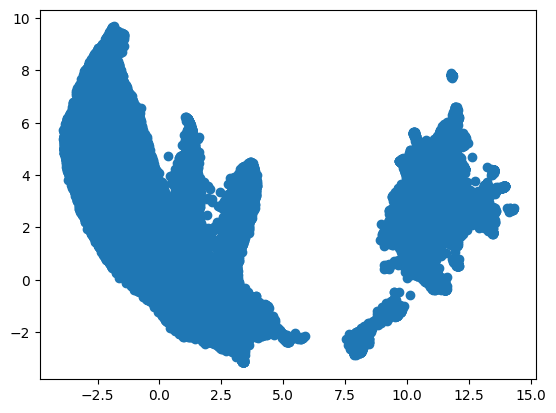

In [ ]:
plt.scatter(
    embedding[:, 0], 
    embedding[:, 1],
)